### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append('../')
import copy, pdb, json, pprint, glob, cv2, logging, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from yaml import safe_load
from utils import load_domain
from detectors import Dataset, MVTechDataset
from hypersearch import OptunaOptimization
from criteria import Label, accuracy, iou, auc_odr
from ext import *
from timeit import default_timer as timer
from detectors import SddCxxPSD, PSDParameter
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support, classification_report

logger = logging.getLogger()
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.INFO)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

### Functions (you can hide drop down after running)

In [3]:
def process_df(df):
  csv = df.reset_index()
  csv['defect'] = csv['class']
  csv['y_true'] = csv['label']
  csvmax = csv.groupby('File name').max()
  return csvmax


def return_metrics(df):
  csv = process_df(df)
  fpr, tpr, thresholds = roc_curve(csv.y_true, csv.Anomaly)
  best_idx = np.argmax(tpr-fpr)
  best_threshold = round(thresholds[best_idx],4)
  best_fpr, best_tpr = round(fpr[best_idx],4), round(tpr[best_idx],4)
  auc = roc_auc_score(csv.y_true, csv.Anomaly)
  gu_preds = csv[csv.y_true==0].Anomaly.apply(lambda x : 0 if x<= best_threshold else 1)
  odr = gu_preds.mean()

  min_fp = csv[csv.okng == 'NG'].Anomaly.min()
  zero_threshold = min_fp - .0001
  zero_odr = len(csv[(csv.okng == 'OK')&(csv.Anomaly > zero_threshold)])/len(csv[(csv.okng == 'OK')])

  print('Mitsubishi Metrics')
  print('\t AUC: %.4f' % auc)
  print('\t Over-detection rate: %.4f' % zero_odr)
  print('\t at zero FP threshold: %.4f \n' % zero_threshold)
  print('Hacarus Metrics (balanced threshold with lowest TPR - FPR)')
  print(f'\t OK accuracy: {round(1-best_fpr,4)}, NG accuracy: {round(best_tpr,4)}')
  print('\t Over-detection rate: %.4f' % odr)
  print(f'\t at balanced threshold: {best_threshold}')

def plot_roc(df):  
  csv = process_df(df)
  fpr, tpr, thresholds = roc_curve(csv.y_true, csv.Anomaly)
  plt.plot(fpr, tpr, label='_nolegend_')
  plt.title('ROC Curve')
  best_idx = np.argmax(tpr-fpr)
  plt.scatter(fpr[best_idx], tpr[best_idx], c='red')
  plt.legend(['best'], loc=7)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')

def zero_acc_by_group(df):
  csv = process_df(df)
  min_fp = csv[csv.okng == 'NG'].Anomaly.min()
  zero_threshold = float(str(min_fp)[:(len(str(min_fp))-1)])
  accs = {}
  for i, df in csv.groupby('defect'):
    if i == 'OK':
      preds = df.Anomaly.apply(lambda x : 1 if x<= zero_threshold else 0)
      acc = preds.mean()
    else:
      preds = df.Anomaly.apply(lambda x : 0 if x<= zero_threshold else 1)
      acc = preds.mean()
    accs[i] = [round(acc,4)]
  return pd.DataFrame(accs)

def zero_conf_matr(df):
  csv = process_df(df)  
  fpr, tpr, thresholds = roc_curve(csv.y_true, csv.Anomaly)
  min_fp = csv[csv.okng == 'NG'].Anomaly.min()
  zero_threshold = min_fp - .0001
  print(min_fp, zero_threshold)
  y_pred = csv.Anomaly.apply(lambda x : 0 if x<= zero_threshold else 1)
  cm = confusion_matrix(csv.y_true, y_pred)
  cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['OK', 'NG'])
  cm_display.plot()

def acc_by_group(df):
  csv = process_df(df)
  fpr, tpr, thresholds = roc_curve(csv.y_true, csv.Anomaly)
  best_idx = np.argmax(tpr-fpr)
  best_threshold = round(thresholds[best_idx],4)
  accs = {}
  for i, df in csv.groupby('defect'):
    if i == 'OK':
      preds = df.Anomaly.apply(lambda x : 1 if x<= best_threshold else 0)
      acc = preds.mean()
    else:
      preds = df.Anomaly.apply(lambda x : 0 if x<= best_threshold else 1)
      acc = preds.mean()
    accs[i] = [round(acc,4)]
  return pd.DataFrame(accs)

def conf_matr(df):
  csv = process_df(df)  
  fpr, tpr, thresholds = roc_curve(csv.y_true, csv.Anomaly)
  best_idx = np.argmax(tpr-fpr)
  best_threshold = round(thresholds[best_idx],4)
  y_pred = csv.Anomaly.apply(lambda x : 0 if x<= best_threshold else 1)
  cm = confusion_matrix(csv.y_true, y_pred)
  cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['OK', 'NG'])
  cm_display.plot()

def plot_scatter(df, log=False):
  #side by side plots
  fig, ax = plt.subplots(1,2, figsize=(15,5))

  csv = process_df(df)
  fpr, tpr, thresholds = roc_curve(csv.y_true, csv.Anomaly)
  best_idx = np.argmax(tpr-fpr)
  best_threshold = round(thresholds[best_idx],4)
  min_fp = csv[csv.okng == 'NG'].Anomaly.min()
  zero_threshold = float(str(min_fp)[:(len(str(min_fp))-1)])

  ax[0].scatter(csv[csv.okng=='OK'].Anomaly, np.random.randint(0,csv.shape[0],csv[csv.okng=='OK'].shape[0]), color='lightgreen')
  ax[0].scatter(csv[csv.okng=='NG'].Anomaly, np.random.randint(0,csv.shape[0],csv[csv.okng=='NG'].shape[0]), color = 'tomato')
  ax[0].vlines(zero_threshold,0,csv.shape[0],color='indigo')
  ax[0].vlines(best_threshold,0,csv.shape[0],color='blue')
  ax[1].set_xscale('log')
  ax[1].scatter(csv[csv.okng=='OK'].Anomaly, np.random.randint(0,csv.shape[0],csv[csv.okng=='OK'].shape[0]), color='lightgreen')
  ax[1].scatter(csv[csv.okng=='NG'].Anomaly, np.random.randint(0,csv.shape[0],csv[csv.okng=='NG'].shape[0]), color = 'tomato')
  ax[1].vlines(zero_threshold,0,csv.shape[0],color='indigo')
  ax[1].vlines(best_threshold,0,csv.shape[0],color='blue')
  #set xticks 
  ax[1].set_xticks([0.1,0.2,0.3,0.4,.5, 0.6], ['0.1','0.2','0.3','0.4','0.5','0.6'])

def plot_hist(df):
  fig, ax = plt.subplots(2,1, figsize=(10,5))
  # plot a histogram of anomaly on axis 0
  # same scale for both plots

  ax[0].hist(df[df.okng=='OK'].Anomaly, bins=100, color='forestgreen');
  ax[0].set_xlim(df.Anomaly.min(),df.Anomaly.max())
  ax[0].set_title('OK')
  ax[1].hist(df[df.okng=='NG'].Anomaly, bins=100, color='tomato');
  ax[1].set_xlim(df.Anomaly.min(), df.Anomaly.max())
  ax[1].set_title('NG')
  ax[1].set_xlabel('Anomaly Score')
  # vertical line on plot
  # space between plots
  plt.subplots_adjust(hspace=0.5)

def anomaly_scatter(df):

  csv = process_df(df)
  fpr, tpr, thresholds = roc_curve(csv.y_true, csv.Anomaly)
  best_idx = np.argmax(tpr-fpr)
  best_threshold = round(thresholds[best_idx],4)
  min_fp = csv[csv.okng == 'NG'].Anomaly.min()
  zero_threshold = float(str(min_fp)[:(len(str(min_fp))-1)])

  ng_colors = ['maroon', 'red','darkorange', 'indianred', 'violet',  'purple', 'darkslateblue', 'cornflowerblue' ]

  for i, (_, class_df) in enumerate(df[df.okng != 'OK'].groupby('class')):
    plt.scatter(class_df.index, class_df.Anomaly, color=ng_colors[i], label=_)

  okdf = df[df.okng == 'OK']
  plt.scatter(okdf.index, okdf.Anomaly, color='forestgreen', label='OK')

  width = len(df)
  plt.axhline(best_threshold, color='darkcyan', zorder=0, label='balanced threshold')
  plt.axhline(zero_threshold, color='darkcyan', zorder=0, label='zero odr threshold', linestyle='--')

  plt.legend(bbox_to_anchor=(1, 1))
  plt.title('Anomaly Score by Class')
  plt.ylabel('Anomaly Score')
  plt.xlabel('Index')

### Dataset

Set dataset name

In [4]:
target = 'pill'

In [5]:
dataset_root = f'../data/{target}/'

train_imgs_path = glob.glob(f'{dataset_root}/train/good/*.png')
train_imgs = [cv2.imread(i) for i in train_imgs_path]

test_imgs_path = glob.glob(f'{dataset_root}/test/ALL/*.png')
test_imgs = [cv2.imread(i) for i in test_imgs_path]
test_labels = []
for path in test_imgs_path:
    if 'OK' in path:
        test_labels.append(0)
    else:
        test_labels.append(1)
        
pd.Series(test_labels).value_counts()

dataset = MVTechDataset(train_imgs_path, train_imgs, test_imgs_path, test_imgs, test_labels)

## Best Model Results

### Train and Inspect with best params

Input best params

In [6]:
#   222	0.000721	0.099135	0.9677	True	False	

In [7]:
best_params = PSDParameter()

best_params.n_features = 222
best_params.ridge = 0.000721	
best_params.r_growth = 0.099135
best_params.b_soe = True
best_params.b_aer = False
# best_params.onnx = '../distfiles/wide_resnet50_2.onnx'
# best_params.names = ('356', '398', '460')
# best_params.onnx = '../distfiles/resnet18.onnx'
best_params.onnx = '../distfiles/resnet18-5c106cde.onnx'
# best_params.names = ('140', '156', '172')

balanced_threshold = 0.9677

In [8]:
best_params

PSDParameter(alg='PatchSampleDetector', license_path='../license/node-locked.lic', onnx='../distfiles/resnet18-5c106cde.onnx', names=('140', '156', '172'), n_features=222, ridge=0.000721, r_growth=0.099135, b_soe=True, b_aer=False)

Initialise best model

In [9]:
psd = SddCxxPSD(best_params)

In [10]:
train_times = []
inference_times = []
interpret_times = []   

Train

In [11]:
# run this a few times to get a low number
st = timer()

psd.fit(dataset.train_imgs)

et = timer() 
trial_train_time = et - st
train_times.append(trial_train_time)
print(f"(trial) training time: {trial_train_time}")

(trial) training time: 43.83180079993326


In [12]:
train_time = np.min(train_times)
print(f"Best Training Time: {trial_train_time}")

Best Training Time: 43.83180079993326


Inference

In [13]:
# run this a few times to get a low number
st = timer()

anomaly_imgs = psd.predict(dataset.test_imgs)

# zhu add for rectangle
rects    = SddCxxRectangleLists()
labels   = SddCxxLabelList()
anomalys = SddCxxAnomalyList()
scs = SddCxxSensitivity()
scs.sen.anomaly = 0.26
scs.sen.area    = 100
psd.interpret(scs = scs, anomaly_imgs = anomaly_imgs, rects = rects, labels = labels, anomalys = anomalys)

et = timer() 
trial_inference_time = et - st
inference_times.append(trial_inference_time)
print(f"(trial) inference time: {trial_inference_time}")

(trial) inference time: 55.43539260001853


In [14]:
inference_time = np.min(inference_times)
print(f"Best Inference Time: {inference_time}")

Best Inference Time: 55.43539260001853


Interpret

In [15]:
# set the number of trials to get a low number
trials = 10

interpret_times = [] 

for i in range(trials):
    st = timer()

    max_anomalys = [np.max(img) for img in anomaly_imgs]
    # loop through the max_anomalys if the  value is above the threshold, then return 1, else return 0
    predictions = [1 if max_anomaly > balanced_threshold else 0 for max_anomaly in max_anomalys]

    et = timer() 
    time = et - st
    interpret_times.append(time)
    if trials < 11:
        print(f"interpret time {i}: {time}")

interpret_time = np.min(interpret_times)
print(f"\nBest Interpret Time: {interpret_time}")

interpret time 0: 0.064660600037314
interpret time 1: 0.05709689995273948
interpret time 2: 0.05534339998848736
interpret time 3: 0.05298430006951094
interpret time 4: 0.05220570007804781
interpret time 5: 0.052685000002384186
interpret time 6: 0.05595469998661429
interpret time 7: 0.055580199928954244
interpret time 8: 0.0548047999618575
interpret time 9: 0.053725300007499754

Best Interpret Time: 0.05220570007804781


All Times

In [16]:
print(f"Best Training Time: {train_time}")
print(f"Best Inference time: {inference_time}")
print(f"Best Interpret Time: {interpret_time}")
print(f"Total Inspection Time: {inference_time + interpret_time}")

Best Training Time: 43.83180079993326
Best Inference time: 55.43539260001853
Best Interpret Time: 0.05220570007804781
Total Inspection Time: 55.48759830009658


### Get detailed info about inspection results

In [17]:
filenames = []
classes = []
for path in test_imgs_path:
    # get the last part of the path
    filename = path.split('\\')[-1]
    filenames.append(filename)  
    #get the text part of the filename
    class_ = filename.split(' ')[0]
    classes.append(class_)

In [18]:
df_dict = {
    'File name': filenames,
    'class': classes,
    'okng': ['OK' if label == 0 else 'NG' for label in test_labels],
    'label': test_labels,
    'prediction': predictions,
    'Anomaly': max_anomalys
}

insp_results = pd.DataFrame(df_dict)

In [19]:
results_path = dataset_root + '/results/'
insp_results_path = results_path + f'/inspection_results.csv'

In [20]:
insp_results.to_csv(insp_results_path, index=False)

In [21]:
insp_results.head()

,File name,class,okng,label,prediction,Anomaly
0,color (1).png,color,NG,1,1,0.977036
1,color (10).png,color,NG,1,1,0.988648
2,color (11).png,color,NG,1,1,0.973880
3,color (12).png,color,NG,1,1,0.992871
4,color (13).png,color,NG,1,1,0.995142


### Plots

In [22]:
return_metrics(insp_results)

print('\n')
print(f"Best Training Time: {train_time}")
print(f"Best Inference time: {inference_time}")
print(f"Best Interpret Time: {interpret_time}")
print(f"Total Inspection Time: {inference_time + interpret_time}")

Mitsubishi Metrics
	 AUC: 0.8740
	 Over-detection rate: 0.8846
	 at zero FP threshold: 0.9352 

Hacarus Metrics (balanced threshold with lowest TPR - FPR)
	 OK accuracy: 0.8077, NG accuracy: 0.9078
	 Over-detection rate: 0.1923
	 at balanced threshold: 0.9677


Best Training Time: 43.83180079993326
Best Inference time: 55.43539260001853
Best Interpret Time: 0.05220570007804781
Total Inspection Time: 55.48759830009658


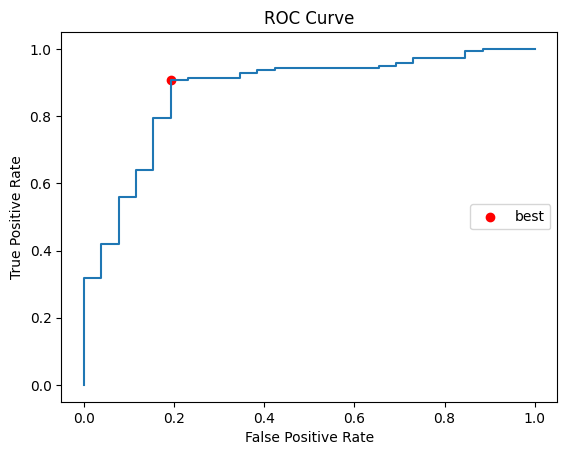

In [23]:
plot_roc(insp_results)

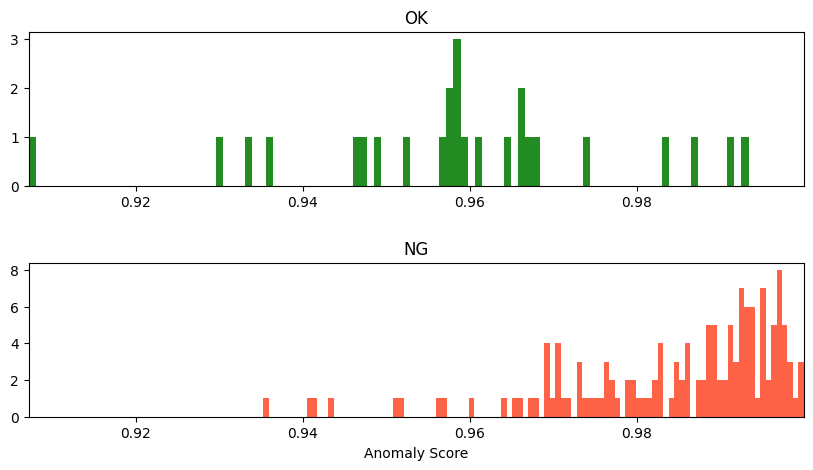

In [24]:
plot_hist(insp_results)

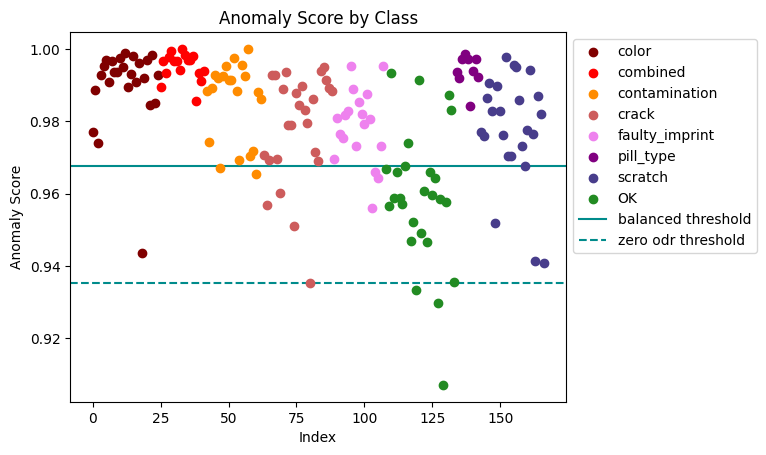

In [25]:
anomaly_scatter(insp_results)

In [26]:
zero_acc_by_group(insp_results)

,OK,color,combined,contamination,crack,faulty_imprint,pill_type,scratch
0,0.1154,1.0,1.0,1.0,1.0,1.0,1.0,1.0


0.935275673866272 0.935175673866272


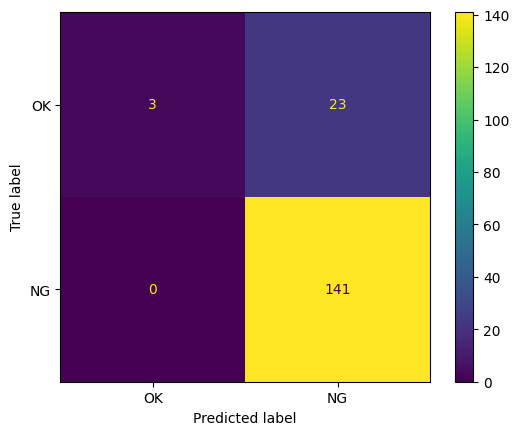

In [27]:
zero_conf_matr(insp_results)

In [28]:
acc_by_group(insp_results)

,OK,color,combined,contamination,crack,faulty_imprint,pill_type,scratch
0,0.8077,0.96,1.0,0.9048,0.8462,0.8421,1.0,0.8333


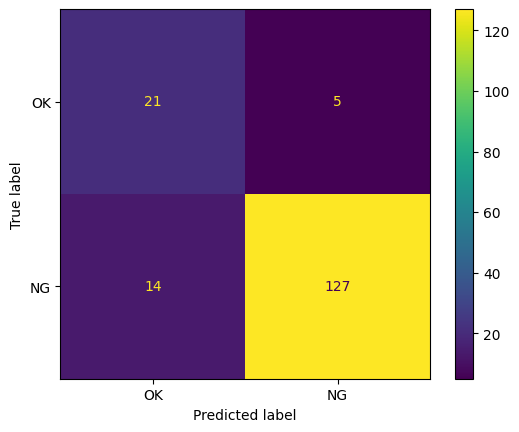

In [29]:
conf_matr(insp_results)

### Images

In [30]:
def to_grayscale_heatmap(
    anomaly_img: np.ndarray
) -> np.ndarray:
    denom = anomaly_img.max()
    if denom == 0:
        hm = np.zeros_like(anomaly_img, dtype = np.uint8)
        return hm
    else:
        scale = 2**8 / denom
        hm = scale * anomaly_img
        hm[hm < 0] = 0
        hm[hm > 2**8 - 1] = 2**8 - 1
        return hm.astype(np.uint8)

def to_overlap_img(
    bg: np.ndarray,
    anomaly_img: np.ndarray
) -> np.ndarray:
    tmp = to_grayscale_heatmap(anomaly_img = anomaly_img)
    hm = cv2.applyColorMap(tmp, cv2.COLORMAP_JET)
    mode = np.argmax(np.bincount(tmp.flatten()))
    hm[tmp <= mode + 5] = 0 # FIXME: Consider better way instead of mode + 5.
    if (len(bg.shape) == 2):
        bg = cv2.cvtColor(bg, cv2.COLOR_GRAY2BGR)
    overlap_img = cv2.addWeighted(bg, 1.0, hm, 0.7, 0)
    return overlap_img

def to_annotate_img(
    bg: np.ndarray,
    rs: SddCxxRectangleList
) -> np.ndarray:
    annotate_img = bg
    color = (0, 0, 255)
    thickness = 4
    logg = False
    for r in rs:
        top_left     = (r.rect.x, r.rect.y)
        bottom_right = (r.rect.x + r.rect.width - 1, r.rect.y + r.rect.height - 1)
        if logg: print(f"top_left: {top_left}, bottom_right: {bottom_right}")
        annotate_img = cv2.rectangle(annotate_img, top_left, bottom_right, color, thickness)
    return annotate_img

In [31]:
gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in dataset.test_imgs]
overlap_imgs = [to_overlap_img(i, j) for (i, j) in zip(gray_images, anomaly_imgs)]
annotate_imgs = [to_annotate_img(i, j) for (i, j) in zip(gray_images, rects)]

In [32]:
# save overlap_imgs in a folder_ ZHU
overlap_imgs_path = results_path + '/overlap_imgs/'
os.makedirs(overlap_imgs_path, exist_ok=True)

for i, overlap_img in enumerate(overlap_imgs):
    filename = filenames[i]
    overlap_img_path = overlap_imgs_path + filename
    cv2.imwrite(overlap_img_path, overlap_img)

# save annotate_imgs in a folder_ ZHU
annotate_imgs_path = results_path + '/annotate_imgs/'
os.makedirs(annotate_imgs_path, exist_ok=True)

for i, annotate_img in enumerate(annotate_imgs):
    filename = filenames[i]
    annotate_img_path = annotate_imgs_path + filename
    cv2.imwrite(annotate_img_path, annotate_img)

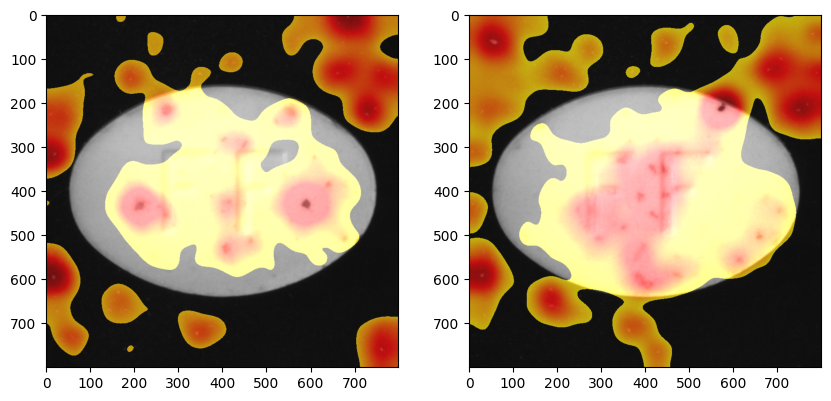

In [33]:
fig, axis = plt.subplots(1, 2, figsize=(10,30))
for ax, img in zip(axis, overlap_imgs):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

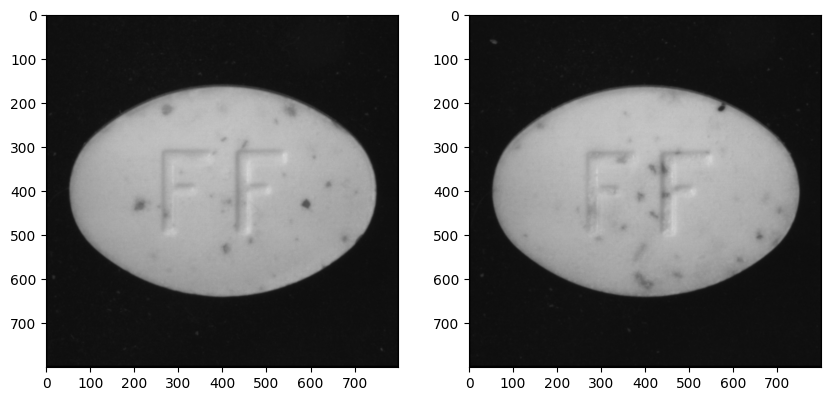

In [34]:
fig, axis = plt.subplots(1, 2, figsize=(10,30))
for ax, img in zip(axis, annotate_imgs):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))